In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torch_pconv import PConv2d  # Using the torch_pconv implementation
from torch.utils.data import Dataset

In [2]:
def pair_color_depth_files(root_dir):
    color_dict = {}
    depth_dict = {}
    
    for directory, _, files in os.walk(root_dir):
        for f in files:
            full_path = os.path.join(directory, f)
            
            # Determine a prefix based on whether we're in a subfolder or not.
            if directory == root_dir:
                prefix_prefix = ""  # Flat structure: don't add folder name.
            else:
                prefix_prefix = os.path.basename(directory) + "_"
            
            # Check file naming conventions and strip specific suffixes:
            if f.endswith("_colors.png"):
                prefix = prefix_prefix + f.replace("_colors.png", "")
                color_dict[prefix] = full_path
            elif f.endswith("_depth.png"):
                prefix = prefix_prefix + f.replace("_depth.png", "")
                depth_dict[prefix] = full_path
            elif f.endswith(".jpg"):
                # For jpg files assume they are color images.
                prefix = prefix_prefix + f.replace(".jpg", "")
                color_dict[prefix] = full_path
            elif f.endswith(".png"):
                # For png files not already handled, assume they are depth images.
                prefix = prefix_prefix + f.replace(".png", "")
                depth_dict[prefix] = full_path
    
    pairs = []
    for prefix, cpath in color_dict.items():
        if prefix in depth_dict:
            pairs.append((cpath, depth_dict[prefix]))
    return pairs


In [3]:
class NYUDepthDataset(Dataset):
    def __init__(self, root_dir, img_size=(480, 640), transform=None, apply_mask=True):
        """
        Args:
            root_dir: Path to the folder containing color/depth pairs (e.g. nyu2_train or nyu2_test).
            img_size: Desired (height, width) for resizing.
            transform: Optional transforms (e.g., Torchvision transforms) after resizing/normalizing.
            apply_mask: Whether to create and apply a random mask.
        """
        super().__init__()
        self.root_dir = root_dir
        self.img_size = img_size
        self.transform = transform
        self.apply_mask = apply_mask

        # Create a list of (color_path, depth_path) pairs
        self.samples = pair_color_depth_files(root_dir)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, depth_path = self.samples[idx]

        # print("color_depth:", color_path)
        # print("depth_path:",  depth_path)

        # ----- Load color image ----- 
        img = cv2.imread(color_path)
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize to (width, height) for OpenCV
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0

        # ----- Load depth image -----
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        depth = cv2.resize(depth, (self.img_size[1], self.img_size[0]))
        depth = depth.astype(np.float32) / 255.0  # Adjust as needed

        # If apply_mask is True, create a random mask and apply it
        if self.apply_mask:
            mask_2d = self.create_random_mask(self.img_size)
            # Expand mask to 3 channels for the color image
            mask_3d = np.stack([mask_2d]*3, axis=-1)

            # Make a copy for the masked versions
            masked_img = img.copy()
            masked_depth = depth.copy()

            # Where mask == 0, set color to 1.0 (white) and depth to 0
            masked_img[mask_3d == 0] = 1.0
            masked_depth[mask_2d == 0] = 0.0
        else:
            # If no mask, just pass the original images
            mask_2d = np.ones((self.img_size[0], self.img_size[1]), dtype=np.float32) * 255
            masked_img = img
            masked_depth = depth

        # ----- Convert to Torch Tensors -----
        # Color images: (H, W, C) -> (C, H, W)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)
        masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1)

        # Depth images: (H, W) -> (1, H, W)
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)
        masked_depth_tensor = torch.from_numpy(masked_depth).unsqueeze(0)

        # Mask: (H, W) -> (1, H, W), normalized to [0, 1]
        mask_tensor = torch.from_numpy(mask_2d.astype(np.float32) / 255.0).unsqueeze(0)

        # Optionally apply user-supplied transforms (e.g. augmentations)
        if self.transform is not None:
            # Typically you might do: (But be careful with how transforms are applied to multi-channel data)
            img_tensor = self.transform(img_tensor)
            masked_img_tensor = self.transform(masked_img_tensor)
            # For depth or mask, you might have a separate transform pipeline or skip

        return {
            "image": img_tensor,          # Original color image
            "masked_image": masked_img_tensor,
            "depth": depth_tensor,        # Original depth map
            "masked_depth": masked_depth_tensor,
            "mask": mask_tensor
        }

    def create_random_mask(self, size):
        """
        Create a random mask of shape (H, W) using random lines.
        White=255 => unmasked, Black=0 => masked.
        """
        H, W = size
        mask = np.full((H, W), 255, np.uint8)

        # Draw a random number of lines
        num_lines = np.random.randint(1, 10)
        for _ in range(num_lines):
            x1, x2 = np.random.randint(0, W, size=2)
            y1, y2 = np.random.randint(0, H, size=2)
            thickness = np.random.randint(1, 3)
            cv2.line(mask, (x1, y1), (x2, y2), 0, thickness)

        return mask


In [4]:
from torch.utils.data import DataLoader

# Example: Using the train folder
train_root = "nyu_data/data/nyu2_train"
train_dataset = NYUDepthDataset(root_dir=train_root, img_size=(240, 320), apply_mask=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Example: Using the test folder
test_root = "nyu_data/data/nyu2_test"
test_dataset = NYUDepthDataset(root_dir=test_root, img_size=(240, 320), apply_mask=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("total number of train dataset:", len(train_dataset))
print("total number of test dataset:",  len(test_dataset))

# Get one batch
sample_batch = next(iter(train_loader))
# print("Keys in the batch:", sample_batch.keys())
# print("image shape:", sample_batch["image"].shape)               # torch.Size([4, 3, 480, 640])
# print("masked_image shape:", sample_batch["masked_image"].shape) # torch.Size([4, 3, 480, 640])
# print("depth shape:", sample_batch["depth"].shape)               # torch.Size([4, 1, 480, 640])
# print("masked_depth shape:", sample_batch["masked_depth"].shape) # torch.Size([4, 1, 480, 640])
# print("mask shape:", sample_batch["mask"].shape)                 # torch.Size([4, 1, 480, 640])

# sample_batch = next(iter(test_loader))
# print("Keys in the batch:", sample_batch.keys())
# print("image shape:", sample_batch["image"].shape)
# print("masked_image shape:", sample_batch["masked_image"].shape)
# print("depth shape:", sample_batch["depth"].shape)
# print("masked_depth shape:", sample_batch["masked_depth"].shape)
# print("mask shape:", sample_batch["mask"].shape)

total number of train dataset: 50688
total number of test dataset: 654


In [5]:
def show_sample(sample_dict, idx=0):
    """
    sample_dict is the dictionary returned by the DataLoader:
      {
        "image": (B, 3, H, W),
        "masked_image": (B, 3, H, W),
        "depth": (B, 1, H, W),
        "masked_depth": (B, 1, H, W),
        "mask": (B, 1, H, W)
      }
    idx is which item in the batch to visualize.
    """
    # Convert Torch tensors -> NumPy, shape (H, W, C). Tensor, shape (C, H, W)
    img_np = sample_dict["image"][idx].permute(1, 2, 0).cpu().numpy()
    masked_img_np = sample_dict["masked_image"][idx].permute(1, 2, 0).cpu().numpy()
    depth_np = sample_dict["depth"][idx].squeeze(0).cpu().numpy()
    masked_depth_np = sample_dict["masked_depth"][idx].squeeze(0).cpu().numpy()
    mask_np = sample_dict["mask"][idx].squeeze(0).cpu().numpy()

    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    axs[0, 0].imshow(img_np)
    axs[0, 0].set_title("Original Image")

    axs[0, 1].imshow(mask_np, cmap='gray')
    axs[0, 1].set_title("Random Mask")

    axs[0, 2].imshow(masked_img_np)
    axs[0, 2].set_title("Masked Image")

    axs[1, 0].imshow(depth_np, cmap='gray')
    axs[1, 0].set_title("Original Depth")

    axs[1, 1].imshow(masked_depth_np, cmap='gray')
    axs[1, 1].set_title("Masked Depth")

    axs[1, 2].axis('off')
    plt.tight_layout()
    plt.show()

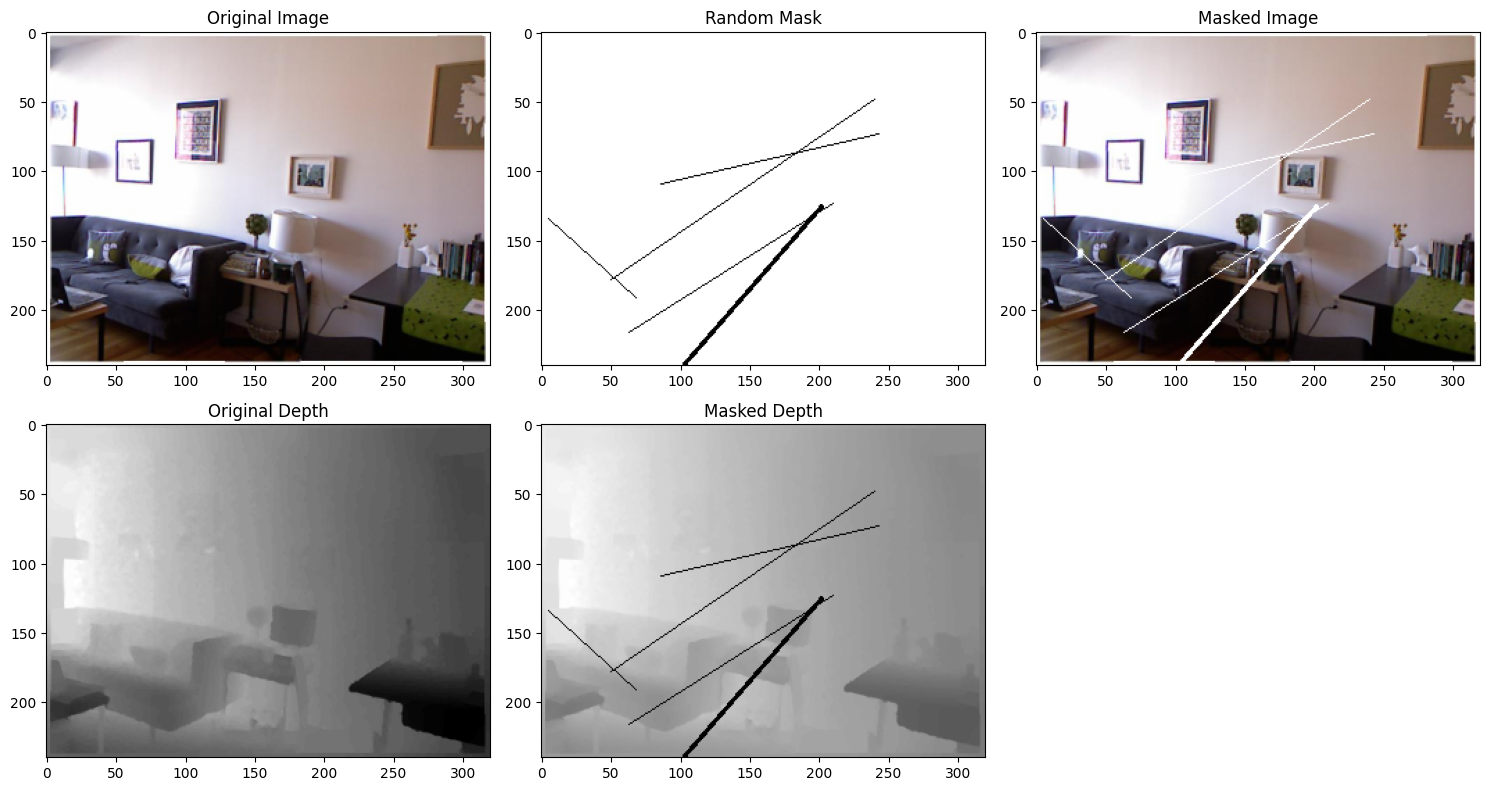

In [6]:
# Visualize first sample in the batch
show_sample(sample_batch, idx=0)

In [7]:
# Partial Convolution Based Autoencoder-Decoder Model

In [8]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.pconv1 = PConv2d(in_channels, out_channels, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels, out_channels, kernel_size=kernel_size, 
                              stride=2, padding=padding, bias=True)
    
    def forward(self, x, mask):
        # Ensure mask is of shape (batch, H, W)
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        x1, mask1 = self.pconv1(x, mask)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels1, out_channels2, kernel_size=3, padding=1):
        super(DecoderBlock, self).__init__()
        self.pconv1 = PConv2d(skip_channels + in_channels, out_channels1, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels1, out_channels2, kernel_size=kernel_size, 
                              stride=1, padding=padding, bias=True)
    
    def forward(self, x, mask, skip_x, skip_mask):
        # Upsample feature map.
        x_up = F.interpolate(x, scale_factor=2, mode='nearest')
        
        # Ensure mask has proper shape before interpolation.
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        mask_up = F.interpolate(mask.unsqueeze(1), scale_factor=2, mode='nearest').squeeze(1)
        
        if skip_mask.dim() == 4 and skip_mask.size(1) == 1:
            skip_mask = skip_mask.squeeze(1)
        # Instead of concatenating masks, combine them via maximum.
        mask_cat = torch.max(skip_mask, mask_up)
        
        # Concatenate image features along the channel dimension.
        x_cat = torch.cat([skip_x, x_up], dim=1)
        
        x1, mask1 = self.pconv1(x_cat, mask_cat)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2


In [10]:
class InpaintingModel(nn.Module):
    def __init__(self, input_channels=3):
        super(InpaintingModel, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 16)
        self.enc2 = EncoderBlock(16, 32)
        self.enc3 = EncoderBlock(32, 64)
        self.enc4 = EncoderBlock(64, 128)
        
        self.dec1 = DecoderBlock(128, 128, 128, 64)
        self.dec2 = DecoderBlock(64, 64, 64, 32)
        self.dec3 = DecoderBlock(32, 32, 32, 16)
        self.dec4 = DecoderBlock(16, 16, 16, 3)
        
        self.final_conv = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
    def forward(self, image, mask):
        # Ensure mask shape is (batch, H, W) before any processing.
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        
        conv1, mask1, conv2, mask2 = self.enc1(image, mask)
        conv3, mask3, conv4, mask4 = self.enc2(conv2, mask2)
        conv5, mask5, conv6, mask6 = self.enc3(conv4, mask4)
        conv7, mask7, conv8, mask8 = self.enc4(conv6, mask6)
        
        conv9, mask9, conv10, mask10 = self.dec1(conv8, mask8, conv7, mask7)
        conv11, mask11, conv12, mask12 = self.dec2(conv10, mask10, conv5, mask5)
        conv13, mask13, conv14, mask14 = self.dec3(conv12, mask12, conv3, mask3)
        conv15, mask15, conv16, mask16 = self.dec4(conv14, mask14, conv1, mask1)
        
        out = self.final_conv(conv16)
        return torch.sigmoid(out)


In [11]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    """
    Dice coefficient metric.
    """
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + epsilon) / (y_true_f.sum() + y_pred_f.sum() + epsilon)

In [12]:
# Set up device, model, optimizer, and loss function.
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"); print(device)
model = InpaintingModel(input_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()  # Mean Absolute Error

cuda


c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        # Retrieve inputs from the batch.
        masked_image = batch["masked_image"].to(device)
        mask = batch["mask"].to(device)
        target = batch["image"].to(device)
        
        optimizer.zero_grad()
        output = model(masked_image, mask)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * masked_image.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [14]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for batch in dataloader:
            masked_image = batch["masked_image"].to(device)
            mask = batch["mask"].to(device)
            target = batch["image"].to(device)
            output = model(masked_image, mask)
            loss = criterion(output, target)
            running_loss += loss.item() * masked_image.size(0)
            total_dice += dice_coef(target, output).item() * masked_image.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_dice = total_dice / len(dataloader.dataset)
    return epoch_loss, epoch_dice

In [15]:
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, test_loader, criterion, device)
    
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

100%|██████████| 3168/3168 [09:50<00:00,  5.37it/s]


Epoch 1/20 - Train Loss: 0.0337 | Val Loss: 0.0224 | Val Dice: 0.6317


100%|██████████| 3168/3168 [08:34<00:00,  6.16it/s]


Epoch 2/20 - Train Loss: 0.0207 | Val Loss: 0.0163 | Val Dice: 0.6294


100%|██████████| 3168/3168 [08:21<00:00,  6.31it/s]


Epoch 3/20 - Train Loss: 0.0157 | Val Loss: 0.0129 | Val Dice: 0.6278


100%|██████████| 3168/3168 [08:17<00:00,  6.36it/s]


Epoch 4/20 - Train Loss: 0.0115 | Val Loss: 0.0100 | Val Dice: 0.6332


100%|██████████| 3168/3168 [10:13<00:00,  5.16it/s]


Epoch 5/20 - Train Loss: 0.0101 | Val Loss: 0.0088 | Val Dice: 0.6307


100%|██████████| 3168/3168 [10:48<00:00,  4.89it/s]


Epoch 6/20 - Train Loss: 0.0093 | Val Loss: 0.0076 | Val Dice: 0.6316


100%|██████████| 3168/3168 [11:18<00:00,  4.67it/s]


Epoch 7/20 - Train Loss: 0.0086 | Val Loss: 0.0080 | Val Dice: 0.6301


100%|██████████| 3168/3168 [11:12<00:00,  4.71it/s]


Epoch 8/20 - Train Loss: 0.0082 | Val Loss: 0.0057 | Val Dice: 0.6314


100%|██████████| 3168/3168 [10:55<00:00,  4.83it/s]


Epoch 9/20 - Train Loss: 0.0079 | Val Loss: 0.0073 | Val Dice: 0.6304


100%|██████████| 3168/3168 [10:43<00:00,  4.93it/s]


Epoch 10/20 - Train Loss: 0.0077 | Val Loss: 0.0082 | Val Dice: 0.6290


100%|██████████| 3168/3168 [10:44<00:00,  4.92it/s]


Epoch 11/20 - Train Loss: 0.0074 | Val Loss: 0.0060 | Val Dice: 0.6304


100%|██████████| 3168/3168 [10:43<00:00,  4.92it/s]


Epoch 12/20 - Train Loss: 0.0073 | Val Loss: 0.0060 | Val Dice: 0.6301


100%|██████████| 3168/3168 [10:44<00:00,  4.92it/s]


Epoch 13/20 - Train Loss: 0.0071 | Val Loss: 0.0059 | Val Dice: 0.6311


100%|██████████| 3168/3168 [11:07<00:00,  4.75it/s]


Epoch 14/20 - Train Loss: 0.0069 | Val Loss: 0.0064 | Val Dice: 0.6334


100%|██████████| 3168/3168 [11:03<00:00,  4.78it/s]


Epoch 15/20 - Train Loss: 0.0068 | Val Loss: 0.0068 | Val Dice: 0.6297


100%|██████████| 3168/3168 [11:08<00:00,  4.74it/s]


Epoch 16/20 - Train Loss: 0.0066 | Val Loss: 0.0060 | Val Dice: 0.6302


100%|██████████| 3168/3168 [11:13<00:00,  4.71it/s]


Epoch 17/20 - Train Loss: 0.0065 | Val Loss: 0.0056 | Val Dice: 0.6319


100%|██████████| 3168/3168 [11:10<00:00,  4.73it/s]


Epoch 18/20 - Train Loss: 0.0064 | Val Loss: 0.0066 | Val Dice: 0.6336


100%|██████████| 3168/3168 [11:04<00:00,  4.77it/s]


Epoch 19/20 - Train Loss: 0.0063 | Val Loss: 0.0067 | Val Dice: 0.6296


100%|██████████| 3168/3168 [11:06<00:00,  4.76it/s]


Epoch 20/20 - Train Loss: 0.0063 | Val Loss: 0.0049 | Val Dice: 0.6320


In [16]:
torch.save(model.state_dict(), "nyu_inpainting_model.pth")